# Importation des packages

In [1]:
#Importation des packages
# Calculs scientifiques
import numpy as np
# Gestion des formats IRM
import nibabel as nib
from scipy.ndimage import zoom
# Création et affichage de graphiques
import matplotlib.pyplot as plt
#Manipulation des donnees 
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from timm.models.layers import DropPath, to_3tuple, trunc_normal_
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim


/home/josh/Documents/3DSPFA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#donner le chemin d'acces pour les images et mask ici pour l'entrainement et le test
path_img_train='data/train/image/'
path_mask_train='data/train/mask/'
path_img_test='data/test/image/'
path_mask_test='data/test/mask/'

In [3]:
def combine_masks_to_single_label(mask_gray, mask_white, mask_csf):
    """
    Combine les masques de matière grise, blanche et liquide céphalo-rachidien (CSF)
    en une seule image qui sert de label pour un modèle de segmentation.

    Les valeurs sont attribuées comme suit :
    - 0 : aucun tissu (background)
    - 1 : matière grise
    - 2 : liquide céphalo-rachidien (CSF)
    - 3 : matière blanche
    """
    # Crée un masque combiné, initialisé à 0 (background)
    combined_mask = np.zeros(mask_gray.shape, dtype=np.uint8)
    
    # Attribue la valeur 2 aux pixels correspondant au CSF
    combined_mask[mask_csf == 1] = 2
    
    # Attribue la valeur 3 aux pixels correspondant à la matière blanche
    combined_mask[mask_white == 1] = 3
    
    # Attribue la valeur 1 aux pixels correspondant à la matière grise
    combined_mask[mask_gray == 1] = 1
    
    return combined_mask



In [4]:
def save_image(img, affine, output_path):
    """ Sauvegarde l'image combinée dans un fichier NIfTI """
    img = nib.Nifti1Image(img, affine)
    nib.save(img, output_path)


In [5]:
def normalize_min_max(image):
    """
    Normalise l'image en utilisant la méthode Min-Max scaling.
    Les valeurs de l'image seront mises à l'échelle entre 0 et 1.

    Paramètre :
    - image : L'image à normaliser (tenseur ou tableau NumPy).

    Retour :
    - image_normalized : L'image normalisée avec des valeurs entre 0 et 1.
    """
    min_val = image.min()  # Valeur minimale dans l'image
    max_val = image.max()  # Valeur maximale dans l'image
    
    # Appliquer la normalisation Min-Max
    image_normalized = (image - min_val) / (max_val - min_val)
    
    return image_normalized


In [6]:
def one_hot_encode(mask, num_classes):
    """
    Effectue un encodage one-hot sur un masque de segmentation.

    Paramètres :
    - mask : Le masque de segmentation, un tableau 3D avec des valeurs d'entiers représentant les classes.
    - num_classes : Le nombre total de classes présentes dans le masque.

    Retour :
    - one_hot : Un tenseur encodé en one-hot avec une dimension ajoutée correspondant aux classes.
    """
    # Assurer que le masque est un tenseur PyTorch de type long (entiers)
    mask = torch.tensor(mask, dtype=torch.long)
    
    # Appliquer l'encodage one-hot (créant une dimension supplémentaire pour les classes)
    one_hot = torch.nn.functional.one_hot(mask, num_classes=num_classes)
    
    return one_hot



In [7]:
#Fonction pour generer des patchs d'entrainement 
def get_sub_volume(image, label,output_x = 128,output_y = 128, output_z = 128, num_classes=4,max_tries = 500, background_threshold=0.95):
 
    # Initialize features and labels with `None`
    X = None
    y = None
    orig_x,orig_y,orig_z=image.shape[0],image.shape[1],image.shape[2]
    tries = 0    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
    
        y = one_hot_encode(y, num_classes=num_classes)

        # compute the background ratio
        y = y.numpy()
        bgrd_ratio = np.sum(y[:,:,:, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z])
            
            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")


In [8]:
# fonction combinant toutes les fonctions de pretraitement : pipeline
def preprocess(image_path, masks_path):
    # Charger les images et les masques
    image = nib.load(image_path).get_fdata()
    m_csf = nib.load(masks_path[0]).get_fdata()
    m_gray=nib.load(masks_path[1]).get_fdata()
    m_white=nib.load(masks_path[2]).get_fdata()
    #Combiner les masks en un seul mask
    mask=combine_masks_to_single_label(mask_gray=m_gray,mask_white=m_white,mask_csf=m_csf)
    #creer des patchs pour l'entrainement:pour l'image et le label ces patchs doivent concorder
    X,y=get_sub_volume(image=image,label=mask)
    #normaliser 
    X=normalize_min_max(X)    
    return X,y

In [9]:
class BrainMRIDataset(Dataset):
    """
    Classe personnalisée pour charger des images IRM cérébrales et leurs masques associés.
    Utilisée pour des tâches de segmentation, avec possibilité d'appliquer des transformations.
    """
    def __init__(self, image_paths, mask_paths, transform=None):
        # Initialise les chemins des images et des masques, et une éventuelle transformation
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        # Retourne la taille du jeu de données (nombre d'images)
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Charge et pré-traite l'image et le masque à l'index donné
        image, mask = preprocess(self.image_paths[idx], self.mask_paths[idx])
        
        # Convertit l'image en tenseur PyTorch et ajoute un canal (dim. 1)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        
        # Convertit le masque en tenseur PyTorch
        mask = torch.tensor(mask, dtype=torch.float32)
        
        # Retourne l'image et le masque
        return image, mask


In [10]:
def load_brain_mri_dataset(path_img, path_mask):
    """
    Charge les chemins des images IRM et des masques, associe les masques à chaque image, 
   

    Paramètres :
    - path_img : Chemin du dossier contenant les images IRM.
    - path_mask : Chemin du dossier contenant les masques (CSF, matière grise, matière blanche).
 
    Retour :
    - df : DataFrame contenant les chemins des images et des masques associés.
    """

    # Obtenir la liste des fichiers d'images et de masques, en triant ceux qui se terminent par '.nii'
    img_files = sorted([f for f in os.listdir(path_img) if f.endswith('.nii')])
    mask_files = sorted([f for f in os.listdir(path_mask) if f.endswith('.nii')])

    # Créer un dictionnaire pour associer les masques (csf, matière grise, matière blanche) à chaque image
    mask_dict = {}
    for mask_file in mask_files:
        # Extraire un nom de base commun pour l'image et les masques
        base_name = '_'.join(mask_file.split('_')[:2])
        
        # Initialiser l'entrée dans le dictionnaire si elle n'existe pas
        if base_name not in mask_dict:
            mask_dict[base_name] = {}
        
        # Associer chaque masque (CSF, Gray Matter, White Matter) à son nom de fichier correspondant
        if 'csf' in mask_file.lower():
            mask_dict[base_name]['csf'] = os.path.join(path_mask, mask_file)
        elif 'graymatter' in mask_file.lower():
            mask_dict[base_name]['graymatter'] = os.path.join(path_mask, mask_file)
        elif 'whitematter' in mask_file.lower():
            mask_dict[base_name]['whitematter'] = os.path.join(path_mask, mask_file)

    # Construire une liste d'images et de masques combinés
    data = []
    for img_file in img_files:
        # Extraire le nom de base pour l'image et l'utiliser pour retrouver les masques associés
        base_name = '_'.join(img_file.split('_')[:2])
        img_path = os.path.join(path_img, img_file)
        
        # Récupérer les masques associés à cette image dans le dictionnaire
        masks = mask_dict.get(base_name, {})
        csf_mask = masks.get('csf', '')
        graymatter_mask = masks.get('graymatter', '')
        whitematter_mask = masks.get('whitematter', '')
        
        # Ajouter à la liste uniquement si tous les masques (csf, graymatter, whitematter) existent
        if csf_mask and graymatter_mask and whitematter_mask:
            data.append([img_path, csf_mask, graymatter_mask, whitematter_mask])

    # Convertir les données en DataFrame pour faciliter la manipulation
    df = pd.DataFrame(data, columns=['Scan', 'CSF Mask', 'Gray Matter Mask', 'White Matter Mask'])
    return df
    

# Implementation du metric d'evaluation:coefficient de similarite Dice

In [11]:
class DiceCoefficient:
    """
    Classe pour calculer et mettre à jour le coefficient de Dice
    sur les prédictions d'un modèle de segmentation.
    """

    def __init__(self):
        # Initialiser la variable pour stocker le coefficient de Dice
        self.dice_coeff = 0

    def update(self, y_pred, y_true):
        """
        Met à jour le coefficient de Dice à partir des prédictions et des vérités terrain.

        Paramètres :
        - y_pred : Les prédictions du modèle (tenseur avec probabilités ou classes prédites).
        - y_true : Les vérités terrain ou labels réels (tenseur avec classes réelles).
        """

        # Calculer l'intersection entre les prédictions et les labels
        intersection = (y_pred * y_true).sum(dim=[2, 3, 4])
        
        # Calculer l'union (la somme des valeurs prédites et réelles)
        union = y_pred.sum(dim=[2, 3, 4]) + y_true.sum(dim=[2, 3, 4])
        
        # Calculer le coefficient de Dice pour chaque exemple
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        
        # Moyenne du coefficient de Dice pour toutes les images du batch
        self.dice_coeff = dice.mean().item()

    def get(self):
        """
        Retourne le coefficient de Dice calculé.
        """
        return self.dice_coeff



# KANLinear

La classe KANLinear est une implémentation d'une couche linéaire avec une approche de B-splines pour modéliser les relations non linéaires entre les entrées et les sorties.

In [12]:

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(
            A, B
        ).solution
        result = solution.permute(
            2, 0, 1
        )

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


In [13]:
# Cette classe effectue une convolution en profondeur 3D, suivie d'une normalisation par lot et d'une activation ReLU
class DW_bn_relu(torch.nn.Module):
    def __init__(self, dim=768):
        super(DW_bn_relu, self).__init__()
        # Use Conv3d 
        self.dwconv = nn.Conv3d(dim, dim, kernel_size=3, stride=1, padding=1, bias=True, groups=dim)
        self.bn = nn.BatchNorm3d(dim)  # Use BatchNorm3d 
        self.relu = nn.ReLU()

    def forward(self, x, D, H, W):
        B, N, C = x.shape
        # Reshape the input tensor to 5D for Conv3d
        x = x.transpose(1, 2).view(B, C, D, H, W)
        x = self.dwconv(x)
        x = self.bn(x)
        x = self.relu(x)
        # Flatten back to the original shape
        x = x.flatten(2).transpose(1, 2)

        return x

## KANLayer 
est une combinaison des couches lineaires KANLinear suivi des couches de convolutions pour une extraction des relations non linear dans les donnees

In [14]:
class KANLayer(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=torch.nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features

        self.fc1 = KANLinear(
            in_features,
            hidden_features,
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        )
        self.fc2 = KANLinear(
            hidden_features,
            out_features,
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        )
        self.fc3 = KANLinear(
            hidden_features,
            out_features,
            grid_size=5,
            spline_order=3,
            scale_noise=0.1,
            scale_base=1.0,
            scale_spline=1.0,
            base_activation=torch.nn.SiLU,
            grid_eps=0.02,
            grid_range=[-1, 1],
        )

        self.dwconv_1 = DW_bn_relu(hidden_features)
        self.dwconv_2 = DW_bn_relu(hidden_features)
        self.dwconv_3 = DW_bn_relu(hidden_features)

        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(2.0))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, D, H, W):
        B, N, C = x.shape
        x = self.fc1(x.reshape(B * N, C)).reshape(B, N, -1)
        x = self.dwconv_1(x, D, H, W)
        x = self.fc2(x.reshape(B * N, -1)).reshape(B, N, -1)
        x = self.dwconv_2(x, D, H, W)
        x = self.fc3(x.reshape(B * N, -1)).reshape(B, N, -1)
        x = self.dwconv_3(x, D, H, W)
        return x


In [15]:

# Un block de convolution avec normalisation et max-pooling
class ConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
        )

    def forward(self, input):
        return self.conv(input)


In [16]:
# Block de deconvulation pour la partie d'expansion
class D_ConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(D_ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, in_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

# Modele Unet avec des blocks KAN

In [17]:
class UKAN(nn.Module):
    def __init__(self, num_classes=4):
        super(UKAN, self).__init__()

        # Encoder
        self.encoder1 = ConvLayer(1, 32)
        self.encoder2 = ConvLayer(32, 64)
        self.encoder3 = ConvLayer(64, 128)

        # KAN Layers encoders
        self.kan1 = KANLayer(in_features=128, hidden_features=256, out_features=256)
        self.kan2 = KANLayer(in_features=256, hidden_features=512, out_features=512)  ### Bottleneck
        # KAN Layers decoders
        self.dbkan1 = KANLayer(in_features=512, hidden_features=256, out_features=256)
        self.dbkan2 = KANLayer(in_features=128, hidden_features=64, out_features=64)

        # Decoder
        self.decoder1 = D_ConvLayer(256, 128)
        self.decoder2 = D_ConvLayer(64, 64)
        self.decoder3 = D_ConvLayer(64, 32)
        self.decoder4=D_ConvLayer(32,32)
        # Output
        self.final_conv = nn.Conv3d(32, num_classes,kernel_size=1)
        self.soft = nn.Softmax(dim=1)


    def forward(self, x):
        # Encoder with Max Pooling
        x1 = F.relu(F.max_pool3d(self.encoder1(x), 2, 2))  # (B, 32, D/2, H/2, W/2)
        t1 = x1
        x2 = F.relu(F.max_pool3d(self.encoder2(x1), 2, 2)) # (B, 64, D/4, H/4, W/4)
        t2 = x2
        x3 = F.relu(F.max_pool3d(self.encoder3(x2), 2, 2)) # (B, 128, D/8, H/8, W/8)
        t3=x3
        # KAN
        B, C, D, H, W = x3.shape
        x = x3.view(B, D * H * W, C)
        #print(x.shape)
        x = self.kan1(x, D, H, W)
        x = self.kan2(x, D, H, W) ### Bottleneck
        x = self.dbkan1(x, D, H, W)

        x = x.reshape(B, 256, D, H, W) 
        #print(x.shape)
        x = F.relu(F.interpolate(self.decoder1(x), scale_factor=(1, 1, 1), mode='trilinear'))
        #print(x.shape,t3.shape)
    
        x = torch.add(x, t3)
        B, C, D, H, W = x.shape
        x = x.view(B, D * H * W, C)
        #print(x.shape)
        x=self.dbkan2(x,D,H,W)
        # Decoder with Upsampling and Skip Connections
        x = x.reshape(B, 64, D, H, W) 
        x = F.relu(F.interpolate(self.decoder2(x), scale_factor=(2, 2, 2), mode='trilinear'))
        x = torch.add(x, t2)  # Skip connection with t2

        x = F.relu(F.interpolate(self.decoder3(x), scale_factor=(2, 2, 2), mode='trilinear'))
        x = torch.add(x, t1)  # Skip connection with t1
        x = F.relu(F.interpolate(self.decoder4(x), scale_factor=(2, 2, 2), mode='trilinear'))
        # Final Convolution
        x = self.final_conv(x)
        return x


In [18]:

num_classes = 4  # Pour une segmentation avec 4 classes background inclu

# Instanciation du modèle
model = UKAN(num_classes=num_classes)

In [19]:
# Paramètres du modèle
in_channels = 1  # Par pour des images en niveaux de gris
# Afficher un résumé du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (1,in_channels, 128, 128, 128))  # Taille d'entrée 

Layer (type:depth-idx)                   Output Shape              Param #
UKAN                                     [1, 4, 128, 128, 16]      --
├─ConvLayer: 1-1                         [1, 32, 128, 128, 16]     --
│    └─Sequential: 2-1                   [1, 32, 128, 128, 16]     --
│    │    └─Conv3d: 3-1                  [1, 32, 128, 128, 16]     896
│    │    └─BatchNorm3d: 3-2             [1, 32, 128, 128, 16]     64
│    │    └─ReLU: 3-3                    [1, 32, 128, 128, 16]     --
│    │    └─Conv3d: 3-4                  [1, 32, 128, 128, 16]     27,680
│    │    └─BatchNorm3d: 3-5             [1, 32, 128, 128, 16]     64
│    │    └─Dropout: 3-6                 [1, 32, 128, 128, 16]     --
│    │    └─ReLU: 3-7                    [1, 32, 128, 128, 16]     --
├─ConvLayer: 1-2                         [1, 64, 64, 64, 8]        --
│    └─Sequential: 2-2                   [1, 64, 64, 64, 8]        --
│    │    └─Conv3d: 3-8                  [1, 64, 64, 64, 8]        55,360
│    │

In [20]:
# Diviser les données en ensembles d'entraînement et de test
train_df, val_df = train_test_split(load_brain_mri_dataset(path_img=path_img_train,path_mask=path_mask_train).head(20), test_size=0.3, random_state=42)

# Créer des jeux de données personnalisés pour l'entraînement et le test
train_dataset = BrainMRIDataset(train_df['Scan'].tolist(), 
                                train_df[['CSF Mask', 'Gray Matter Mask', 'White Matter Mask']].values)
val_dataset = BrainMRIDataset(val_df['Scan'].tolist(), 
                            val_df[['CSF Mask', 'Gray Matter Mask', 'White Matter Mask']].values)

# Créer des DataLoaders pour l'entraînement et le test
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)


# Entrainement du modele

In [21]:
# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Initialisation des listes pour stocker les pertes et le Dice Coefficient
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []

# Boucle d'entraînement
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    dice_metric = DiceCoefficient()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Ici l'optimiseur est utilisé

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Vérification des dimensions des tenseurs
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dice_metric.update(outputs, labels)


    # Calculer les métriques de l'époque en cours
    epoch_loss = running_loss / len(train_loader)
    epoch_dice = dice_metric.get()

    # Ajouter les métriques aux listes
    train_losses.append(epoch_loss)
    train_dice_scores.append(epoch_dice)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}, Dice Coefficient: {epoch_dice}")

    # Évaluation sur le jeu de validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        dice_metric = DiceCoefficient()

        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            dice_metric.update(outputs, labels)

        # Calculer les métriques de validation de l'époque en cours
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_dice = dice_metric.get()

        # Ajouter les métriques de validation aux listes
        val_losses.append(epoch_val_loss)
        val_dice_scores.append(epoch_val_dice)

        print(f"Validation Loss: {epoch_val_loss}, Dice Coefficient: {epoch_val_dice}")


Epoch 1/4, Loss: 1.2899399995803833, Dice Coefficient: 0.23512837290763855
Validation Loss: 1.3473094304402669, Dice Coefficient: 0.0342818945646286


## Visulisation de la variation de la focntion de perte pour l'entrainement et l'evaluation

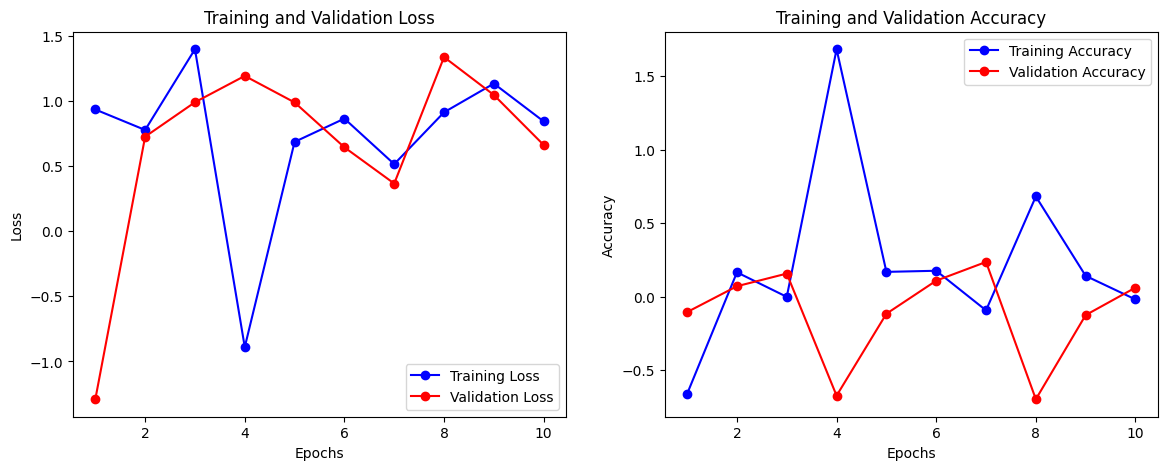

In [50]:
epochs = list(range(1, 11))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_dice_scores, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_dice_scores, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test du modele

In [ ]:
# creer le dataset de test
test_df = load_brain_mri_dataset(path_img=path_img_test,path_mask=path_mask_test).head(10)

# Créer des jeux de données personnalisés pour le test

test_dataset = BrainMRIDataset(test_df['Scan'].tolist(), 
                            test_df[['CSF Mask', 'Gray Matter Mask', 'White Matter Mask']].values)
# Créer des DataLoaders pour  le test
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4)


In [2]:
test_losses = []
test_dice_scores = []

# Passer en mode évaluation
model.eval()
with torch.no_grad():
    test_loss = 0.0
    dice_metric = DiceCoefficient()

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        dice_metric.update(outputs, labels)

    # Calculer les métriques de test
    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_dice = dice_metric.get()

    # Ajouter les métriques de test aux listes
    test_losses.append(epoch_test_loss)
    test_dice_scores.append(epoch_test_dice)

    print(f"Test Loss: {epoch_test_loss}, Dice Coefficient: {epoch_test_dice}")


NameError: name 'model' is not defined

### Fonction pour visualiser une image avec le mask reelle et le mask predit pour une classe particuliere

In [67]:
# Visualiser les résultats
def display_results(test_image, true_mask, predicted_mask, slice_index):
    plt.figure(figsize=(15, 5))

    # Afficher une coupe de l'image de test
    plt.subplot(1, 3, 1)
    plt.imshow(test_image[0, :, slice_index, :], cmap='gray')
    plt.title('Image de Test (Coupe)')
    plt.show()

    # Afficher le masque réel correspondant
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[2, :, slice_index,:], cmap='gray') #changer l'index 2:matiere blanche par 0:pour la matiere grise,1:pour le liquide cephalo-rachidien
    plt.title('Masque relle (Combinaison des Classes)')
    plt.show()
    
    # Afficher le masque predit
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[2, :, slice_index,:], cmap='gray') #changer l'index 2:matiere blanche par 0:pour la matiere grise,1:pour le liquide cephalo-rachidien
    plt.title('Masque Prédit (Combinaison des Classes)')
    plt.show()

    plt.show()

In [1]:
model.eval()
# Sélectionner une image de test
with torch.no_grad():
    test_image, test_mask = next(iter(test_loader))  # Charger une image de test du DataLoader
    test_image = test_image.to(device)
    test_mask = test_mask.to(device)

    # Obtenir les prédictions du modèle
    output = model(test_image)
    print(test_image.shape, output.shape, test_mask.shape)
  
    # Convertir les tenseurs en numpy pour l'affichage
    test_image_np = test_image[1].cpu().numpy()  # Sélectionner le premier exemple
    test_mask_np = test_mask[1].cpu().numpy()       # Sélectionner le premier exemple
    pred_mask_np = output[1].cpu().numpy()       # Sélectionner le premier exemple

    slice_idx = 32  # Par exemple, la coupe au milieu
    threshold = 0.5
    pred_mask_np[pred_mask_np > threshold] = 1.0
    pred_mask_np[pred_mask_np <= threshold] = 0.0
    
    # Afficher une coupe
    display_results(test_image_np, test_mask_np, pred_mask_np, slice_idx)


NameError: name 'model' is not defined